In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import imageio
import numpy as np
import time

from tensorflow.keras import layers
from IPython import display

tf.__version__

'2.0.0-beta1'

In [0]:
!unzip -q '/content/drive/My Drive/Images.zip' -d 'temp'

In [0]:
dir_path = os.path.join(os.getcwd(), 'temp')
images = [os.path.join(dir_path, fname) for fname in os.listdir(dir_path)]

In [0]:
def parse_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, [128, 128])
    return img

(128, 128, 1)


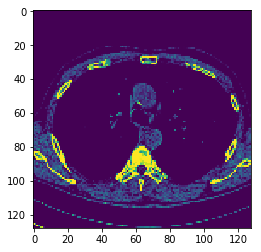

In [0]:
img = parse_image(images[0])
print(img.shape)
plt.imshow(img[:,:,0])

In [0]:
BUFFER_SIZE = 1000
BATCH_SIZE = 100

In [0]:
# shuffle and batch the dataset
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.map(parse_image)

In [0]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
# generator

def make_generator_model():
    model = tf.keras.Sequential()

    # first layer
    model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8,8,128)))
    assert model.output_shape == (None, 8, 8, 128)

    # 2nd  layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 3rd layer
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(4, 4), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 4th layer
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 1)

    return model

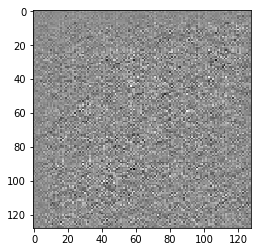

In [0]:
# check the model
generator = make_generator_model()
noise = tf.random.normal([1, 100])
gen_image = generator(noise, training = False)
plt.imshow(gen_image[0, :, :, 0], cmap='gray')

In [0]:
# discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()

    # 1st layer
    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same', input_shape = [128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 2nd layer
    model.add(layers.Conv2D(64, (5, 5), strides=(4, 4), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 3rd layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
# test the model
discriminator = make_discriminator_model()
desicion = discriminator(gen_image)
print(desicion)

tf.Tensor([[0.00036862]], shape=(1, 1), dtype=float32)


In [0]:
# loss function
cross_entropy = tf.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
# saving checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
# define the loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 25

# to visualize the progress in GIF overtime
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print('Epoch: {}'.format(epoch+1))
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # produce images
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)

        # save the model
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec.'.format(epoch+1, time.time() - start))
    
    # generate after final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [0]:
# generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(5,5))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

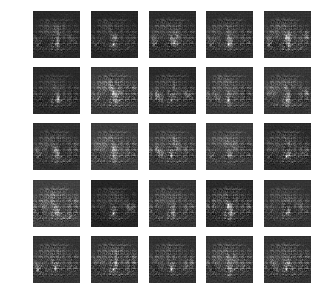

CPU times: user 57min 53s, sys: 2min 50s, total: 1h 43s
Wall time: 45min 43s


In [0]:
# train the model
%%time
train(dataset, EPOCHS)

In [0]:
import glob

anim_file = 'lungan_1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)

    last = -1

    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
!zip '/content/training_checkpoints.zip' '/content/training_checkpoints'

  adding: content/training_checkpoints/ (stored 0%)
